In [1]:
using Convex, SCS, Plots, Statistics, LinearAlgebra, Random, LIBSVMdata

In [2]:
Random.seed!(1234)

TaskLocalRNG()

In [3]:
A, b = load_dataset("a1a", dense=true)

n = size(A, 1)
shuffle = randperm(n)
train_idx = shuffle[1:Int(0.8n)]
test_idx = shuffle[Int(0.8n)+1:end]

Atrain = A[train_idx, :]
btrain = b[train_idx]
Atest = A[test_idx, :]
btest = b[test_idx]

The data a1a was already downloaded
Loading the dataset...


0.0%┣                                             ┫ 0/1.6k [00:00<00:-2, -0s/it]
20.3%┣████████▏                               ┫ 326/1.6k [00:00<00:01, 2.4kit/s]
100.0%┣█████████████████████████████████████┫ 1.6k/1.6k [00:00<00:00, 10.5kit/s]
100.0%┣█████████████████████████████████████┫ 1.6k/1.6k [00:00<00:00, 10.5kit/s]


321-element Vector{Float64}:
 -1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
 -1.0
  ⋮
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0

### Lambda

In [4]:
λ = 1e-4

0.0001

In [5]:
function compute_condition_number(A)
    S = svd(A)
    max = maximum(S.S)
    min = minimum(S.S)
    κ = (max^2 + λ) / (min^2 + λ)
    return κ
end

compute_condition_number(Atrain)

8.089970048251791e7

In [6]:
x1 = Variable(size(Atrain, 2))
n = size(Atrain, 1)
lsProblem = minimize((0.5 / n) * sumsquares((Atrain * x1 - btrain)) + 0.5 * λ * sumsquares(x1))

solve!(lsProblem, SCS.Optimizer)

println("Optimal value: ", lsProblem.optval)
println("Optimal x: ", x1.value)

┌ Info: [Convex.jl] Compilation finished: 2.34 seconds, 520.525 MiB of memory allocated
└ @ Convex /Users/junhyun/.julia/packages/Convex/8Dpiy/src/solution.jl:107


------------------------------------------------------------------
	       SCS v3.2.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 125, constraints m: 1411
cones: 	  q: soc vars: 1411, qsize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
	  compiled with openmp parallelization enabled
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 17937, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.35e+01  4.46e-01  1.46e+01  7.30e+00  1.00e-01  1.04e-02 
   250| 1.12e-01  2.75e-04  2.02e-02  2.95e-01  7.08e-05  2.20e-02 
   500| 3.99e

$P(w) \;=\; \frac{1}{2n}\|Aw-b\|^2 + \frac{1}{2}\lambda\|w\|^2$

In [7]:
function f(x)
    n = size(Atrain, 1)
    return (0.5 / n) * norm(Atrain * x - btrain)^2 + 0.5 * λ * dot(x, x)
end

function ∇f(x, A, b)
    n = size(A, 1)
    return (1 / n) * A' * (A * x - b) + λ * x
end

∇f (generic function with 1 method)

In [8]:
struct ErrorRateTrace
    train::Vector{Float64}
    test::Vector{Float64}
    loss::Vector{Float64}
    variance::Vector{Float64}
end

ErrorRateTrace() = ErrorRateTrace([], [], [], [])

function update!(t::ErrorRateTrace, x)
    push!(t.loss, f(x))
end

update! (generic function with 1 method)

In [9]:
function beststep(d)
    result = []
    stepsize = []

    for c in 1.0:-0.025:0.025
        x, _ = d(∇f, x, Atrain, btrain, c)
        push!(stepsize, c)
        push!(result, abs(f(x) - f(x1.value)))
    end

    stepsize[argmin(result)]

    safe_result = replace(result, NaN => Inf)
    return stepsize[argmin(safe_result)]
end

beststep (generic function with 1 method)

### Iteration

In [10]:
iter = 20

20

In [11]:
function final_result(∇f, x, A, b, trace)
    final_grad = ∇f(x, A, b)
    n_train = size(A, 1)    
    println("Final gradient norm: ", norm(final_grad))
    println("Final Loss: ", trace.loss[end])
end

final_result (generic function with 1 method)

### Gradient Descent

In [12]:
function gd(∇f, x, A, b, α; tol=1e-16, max_iters=10_000)
    trace = ErrorRateTrace()
    
    update!(trace, x)
    
    for k in 1:max_iters
        d = ∇f(x, A, b)
        x = x - α * d
        
        update!(trace, x)

        if norm(d) < tol
            break
        end
    end
    return x, trace
end

gd (generic function with 1 method)

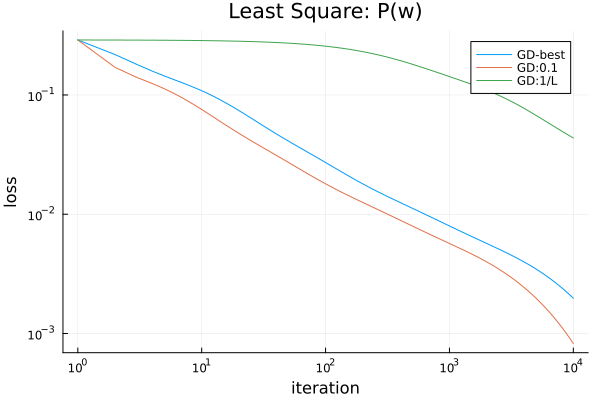

In [13]:
function update!(t::ErrorRateTrace, x)
    push!(t.loss,f(x)-f(x1.value))
end

L = 0.25 * norm(Atrain, 2)^2 + λ
α = 0.1 / L

x = zeros(size(Atrain, 2))
x_gd, trace_gd01 = gd(∇f, x, Atrain, btrain, 0.1)
x_gd, trace_gd05 = gd(∇f, x, Atrain, btrain, 0.05)
x_gdL, trace_gdL = gd(∇f, x, Atrain, btrain, 10*α)
lr_gd_loss = plot(xscale=:log10, yscale=:log10, xlabel="iteration", ylabel="loss", title="Least Square: P(w)", label="GD:0.01")
plot!(lr_gd_loss, trace_gd05.loss, label="GD-best")
plot!(lr_gd_loss, trace_gd01.loss, label="GD:0.1")
plot!(lr_gd_loss, trace_gdL.loss, label="GD:1/L")


plot(lr_gd_loss, layout=(2, 1))
display(lr_gd_loss)

In [14]:
L

4452.5001

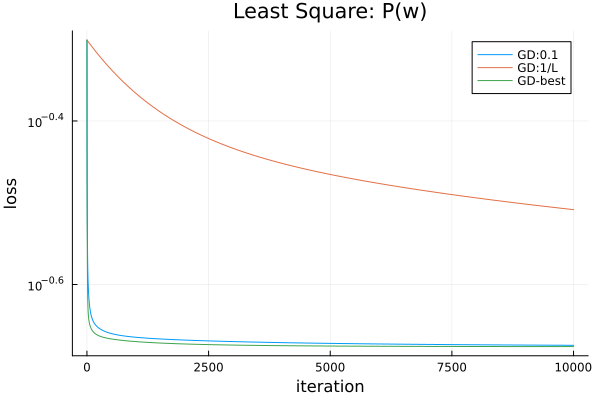

In [15]:
function update!(t::ErrorRateTrace, x)
    push!(t.loss,f(x))
end

L = norm(Atrain, 2)^2 + λ
α = 1 / L

x = zeros(size(Atrain, 2))
x_gd1, trace_gd1 = gd(∇f, x, Atrain, btrain, 0.1)
x_gdB, trace_gdB = gd(∇f, x, Atrain, btrain, 0.3)
x_gdL, trace_gdL = gd(∇f, x, Atrain, btrain, α)

ls_gd_loss = plot(yscale=:log10, xlabel="iteration", ylabel="loss", title="Least Square: P(w)")
plot!(ls_gd_loss, trace_gd1.loss, label="GD:0.1")
plot!(ls_gd_loss, trace_gdL.loss, label="GD:1/L")
plot!(ls_gd_loss, trace_gdB.loss, label="GD-best")

plot(ls_gd_loss, layout=(2, 1))
display(ls_gd_loss)

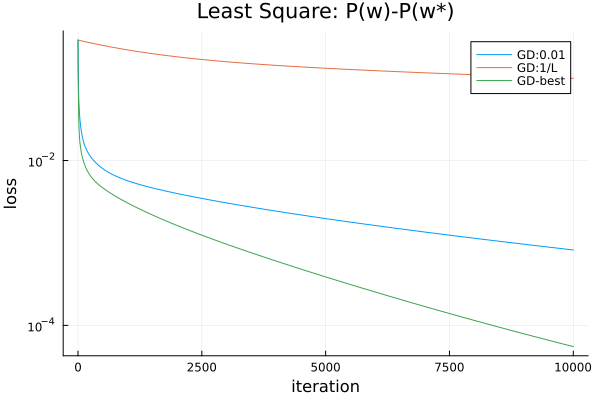

In [16]:
function update!(t::ErrorRateTrace, x)
    push!(t.loss, abs(f(x)-f(x1.value)))
end

L = norm(Atrain, 2)^2 + λ
α = 1 / L

x = zeros(size(Atrain, 2))
x_gd1, trace_gd1 = gd(∇f, x, Atrain, btrain, 0.1)
x_gdB, trace_gdB = gd(∇f, x, Atrain, btrain, 0.3)
x_gdL, trace_gdL = gd(∇f, x, Atrain, btrain, α)

ls_gd_residual = plot(yscale=:log10, xlabel="iteration", ylabel="loss", title="Least Square: P(w)-P(w*)")
plot!(ls_gd_residual, trace_gd1.loss, label="GD:0.01")
plot!(ls_gd_residual, trace_gdL.loss, label="GD:1/L")
plot!(ls_gd_residual, trace_gdB.loss, label="GD-best")

plot(ls_gd_residual, layout=(2, 1))
display(ls_gd_residual)

### SGD

In [17]:
function sgd(∇f, x, A, b, c; batch_size=1, tol=1e-6, max_iter=iter) 
    trace = ErrorRateTrace()

    n = size(A, 1)

    iter = Int(max_iter * n * 3 / batch_size)

    update!(trace, x)

    for k in 1:iter
        batch = randperm(n)[1:batch_size]
        A_batch = A[batch, :]
        b_batch = b[batch]

        α = c / sqrt(k)

        g = ∇f(x, A_batch, b_batch)

        x = x - α * g

        if Int(k * batch_size) % n  == 0
            update!(trace, x)
        end
    end
    return x, trace
end

sgd (generic function with 1 method)

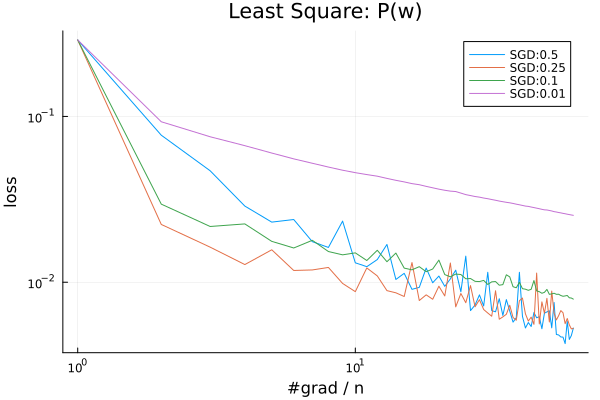

Final gradient norm: 0.08075177568669915
Final Loss: 0.005286149751389024


In [18]:
function update!(t::ErrorRateTrace, x)
    push!(t.loss, f(x)-f(x1.value))
end

x = zeros(size(Atrain, 2))
x_sgd5, trace_sgd5 = sgd(∇f, x, Atrain, btrain, 0.5)
x_sgd25, trace_sgd25 = sgd(∇f, x, Atrain, btrain, 0.25)
x_sgd1, trace_sgd1 = sgd(∇f, x, Atrain, btrain, 0.1)
x_sgd01, trace_sgd01 = sgd(∇f, x, Atrain, btrain, 0.01)

p_ls_sgd = plot(xscale=:log10, yscale=:log10, xlabel="#grad / n", ylabel="loss", title="Least Square: P(w)", legend=:topright)
plot!(p_ls_sgd, trace_sgd5.loss, label="SGD:0.5")
plot!(p_ls_sgd, trace_sgd25.loss, label="SGD:0.25")
plot!(p_ls_sgd, trace_sgd1.loss, label="SGD:0.1")
plot!(p_ls_sgd, trace_sgd01.loss, label="SGD:0.01")
plot!(p_ls_sgd, linewidth=2, grid=true)

display(p_ls_sgd)
final_result(∇f, x_sgd5, Atrain, btrain, trace_sgd5)

### Stochastic Variance Reduced Gradient

In [19]:
function svrg(∇f, x, A, b, α; batch_size=1, outer_iter=iter, inner_iter=2*size(Atrain, 1), option="I")
    trace = ErrorRateTrace()
    n = size(A, 1)

    # x0 = zeros(size(Atrain, 2))
    # x, _ = sgd(∇f, x0, Atrain, btrain, 0.45, max_iter=1)

    update!(trace, x)

    for j in 1:outer_iter
        x_t = copy(x)
        μ = ∇f(x_t, A, b)
        update!(trace, x)

        w_history = Vector{typeof(x)}()

        push!(w_history, copy(x))

        for k in 1:inner_iter
            batch = randperm(n)[1:batch_size] 
            A_batch = A[batch, :]
            b_batch = b[batch]

            g = ∇f(x, A_batch, b_batch)
            # g_t = ∇f(x_t, A_batch, b_batch)

            z_t = A_batch * x_t
            residual_t = z_t - b_batch
            g_t = A_batch' * residual_t / batch_size + λ * x_t

            x = x - α * (g - g_t + μ)

            push!(w_history, copy(x)) 

            if k % n == 0
                update!(trace, x)
            end
        end 
    
        if option == "I"
            x = copy(w_history[end])
        elseif option == "II"
            x = copy(w_history[rand(1:inner_iter)])
        end
    end     

    return x, trace
end

svrg (generic function with 1 method)

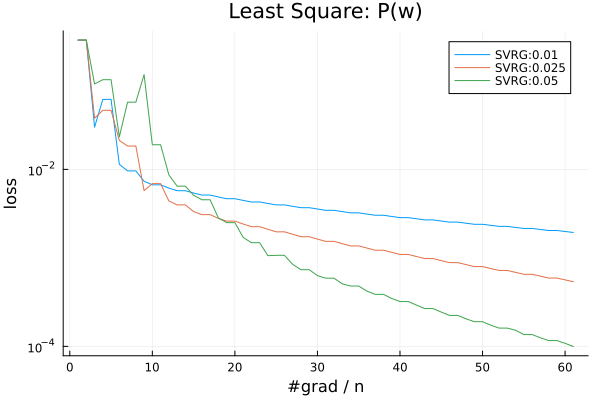

Final gradient norm: 0.0011905438254993215
Final Loss: 0.0005377700861672052


In [20]:
function update!(t::ErrorRateTrace, x)
    push!(t.loss,  f(x)-f(x1.value))
end

α = 0.025

x = zeros(size(Atrain, 2))
x_svrg, trace_svrg = svrg(∇f, x, Atrain, btrain, α)
x_svrg01, trace_svrg01 = svrg(∇f, x, Atrain, btrain, 0.01)
x_svrg05, trace_svrg05 = svrg(∇f, x, Atrain, btrain, 0.05)

p_ls_svrg = plot(yscale=:log10, xlabel="#grad / n", ylabel="loss", title="Least Square: P(w)", legend=:topright)
plot!(p_ls_svrg, trace_svrg01.loss, label="SVRG:0.01")
plot!(p_ls_svrg, trace_svrg.loss, label="SVRG:0.025")
plot!(p_ls_svrg, trace_svrg05.loss, label="SVRG:0.05")

display(p_ls_svrg)
final_result(∇f, x_svrg, Atrain, btrain, trace_svrg)

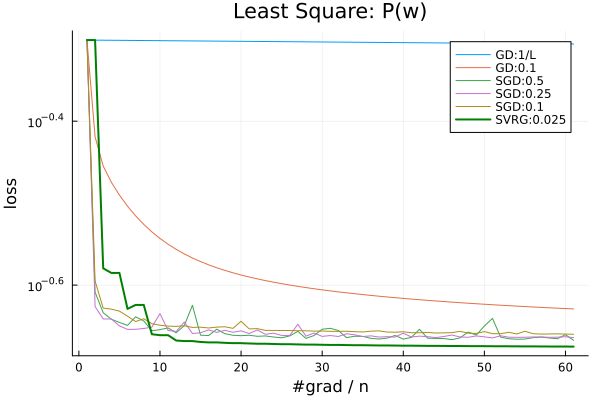

In [21]:
function update!(t::ErrorRateTrace, x)
    push!(t.loss, f(x))
end

L = norm(Atrain, 2)^2 + λ
α = 1 / L

_, trace_gd01 = gd(∇f, x, Atrain, btrain, 0.1, max_iters=iter*3)
_, trace_gdL = gd(∇f, x, Atrain, btrain, α, max_iters=iter*3)

_, trace_sgd50 = sgd(∇f, x, Atrain, btrain, 0.50)
_, trace_sgd25 = sgd(∇f, x, Atrain, btrain, 0.25)
_, trace_sgd10 = sgd(∇f, x, Atrain, btrain, 0.10)

x_svrg, trace_svrg = svrg(∇f, x, Atrain, btrain, 0.025)

p1 = plot(yscale=:log10, xlabel="#grad / n", ylabel="loss", title="Least Square: P(w)", legend=:topright)
plot!(p1, trace_gdL.loss, label="GD:1/L")
plot!(p1, trace_gd01.loss, label="GD:0.1")

plot!(p1, trace_sgd50.loss, label="SGD:0.5")
plot!(p1, trace_sgd25.loss, label="SGD:0.25")
plot!(p1, trace_sgd10.loss, label="SGD:0.1")

plot!(p1, trace_svrg.loss, label="SVRG:0.025", linewidth = 2, color = :green)
plot!(p1, linewidth=2, grid=true)

display(p1)

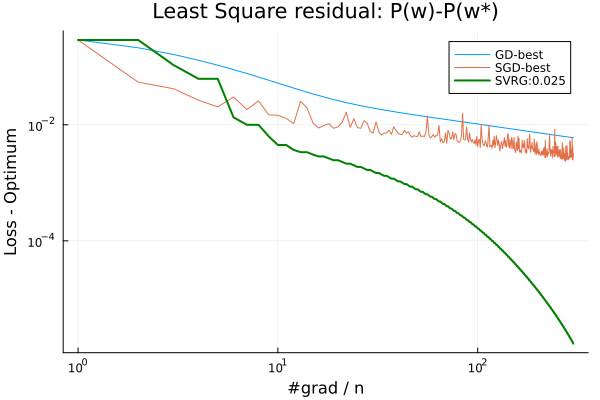

In [22]:
function update!(t::ErrorRateTrace, x)
    push!(t.loss, f(x) - f(x1.value))
end

iter = 100

_, trace_gd03 = gd(∇f, x, Atrain, btrain, 0.3, max_iters=iter*3)
# _, trace_gdL = gd(∇f, x, Atrain, btrain, α, max_iters=iter*3)

# _, trace_sgd10 = sgd(∇f, x, Atrain, btrain, 0.10)
x_sgd45, trace_sgd45 = sgd(∇f, x, Atrain, btrain, 0.45)
x_svrg, trace_svrg = svrg(∇f, x, Atrain, btrain, 0.025)

p2 = plot(xscale = :log10, yscale = :log10, xlabel = "#grad / n", ylabel = "Loss - Optimum", title = "Least Square residual: P(w)-P(w*)", legend = :topright)

# plot!(p2, trace_gdL.loss, label="GD:1/L")
plot!(p2, trace_gd03.loss, label="GD-best")

# plot!(p2, (trace_sgd10.loss), label = "SGD:0.1")
plot!(p2, (trace_sgd45.loss), label = "SGD-best")
plot!(p2, (trace_svrg.loss), label = "SVRG:0.025", linewidth = 2, color = :green)
plot!(p2, linewidth=2, grid=true)

display(p2)

In [23]:
final_result(∇f, x_sgd45, Atrain, btrain, trace_sgd45)

Final gradient norm: 0.08329819014346497
Final Loss: 0.0032308249593558103


In [24]:
final_result(∇f, x_svrg, Atrain, btrain, trace_svrg)

Final gradient norm: 6.315689319182155e-5
Final Loss: 1.691722875368784e-6


In [32]:
0.0032308249593558103/1.691722875368784e-6

1909.7838105732965

### Iterate for Variance

In [25]:
iter = 30

30

In [26]:
function variance_sgd(x, xtilde, A, b)
    n = size(A, 1)
    full_grad = ∇f(x, A, b)
    var_sum = 0.0

    for i in 1:n
        A_i = A[i:i, :]
        b_i = b[i:i]
        g_i = ∇f(x, A_i, b_i)
        var_sum += norm(g_i - full_grad)^2
    end

    return var_sum / n
end

variance_sgd (generic function with 1 method)

In [27]:
function variance_svrg(x_prev, xtilde, A, b)
    n = size(A, 1)
    full_grad_prev = ∇f(x_prev, A, b) 
    full_grad_xtilde = ∇f(xtilde, A, b)
    var_sum = 0.0

    for i in 1:n
        A_i = A[i:i, :]
        b_i = b[i:i]

        g_prev = ∇f(x_prev, A_i, b_i) 
        g_xtilde = ∇f(xtilde, A_i, b_i)

        g_svrg_i = g_prev - g_xtilde + full_grad_xtilde

        var_sum += norm(g_svrg_i - full_grad_prev)^2
    end

    return var_sum / n
end

variance_svrg (generic function with 1 method)

In [28]:
function update!(t::ErrorRateTrace, x, var; xtilde=nothing)
    push!(t.variance, var(x, xtilde, Atrain, btrain))
end

update! (generic function with 2 methods)

In [29]:
function sgd(∇f, x, A, b, c, var; batch_size=1, tol=1e-6, max_iter=iter) 
    trace = ErrorRateTrace()

    n = size(A, 1)

    iter = Int(max_iter * n * 3 / batch_size)

    for k in 1:iter
        batch = randperm(n)[1:batch_size]
        A_batch = A[batch, :]
        b_batch = b[batch]

        α = c / sqrt(k)
        g = ∇f(x, A_batch, b_batch)

        x = x - α * g

        if Int(k * batch_size * 2) % (3 * n)  == 0
            update!(trace, x, var)
        end
    end
    return x, trace
end

sgd (generic function with 2 methods)

In [30]:
function svrg(∇f, x, A, b, α, var; batch_size=1, outer_iter=iter, inner_iter=2*size(Atrain, 1), option="I")
    trace = ErrorRateTrace()
    n = size(A, 1)

    x0 = zeros(size(Atrain, 2))
    x, _ = sgd(∇f, x0, Atrain, btrain, 0.45, max_iter=1)

    for j in 1:outer_iter
        x_t = copy(x)
        μ = ∇f(x_t, A, b)

        w_history = Vector{typeof(x)}()
        push!(w_history, copy(x))

        for k in 1:inner_iter
            batch = randperm(n)[1:batch_size]
            A_batch = A[batch, :]
            b_batch = b[batch]

            g = ∇f(x, A_batch, b_batch)
            g_t = ∇f(x_t, A_batch, b_batch)

            x = x - α * (g - g_t + μ)
            push!(w_history, copy(x))

            if k % n == 0
                w_prev = w_history[end - 1]
                update!(trace, w_prev, var, xtilde=x_t)
            end
        end

        if option == "I"
            x = copy(w_history[end])
        elseif option == "II"
            x = copy(w_history[rand(1:inner_iter)])
        end
    end

    return x, trace
end

svrg (generic function with 2 methods)

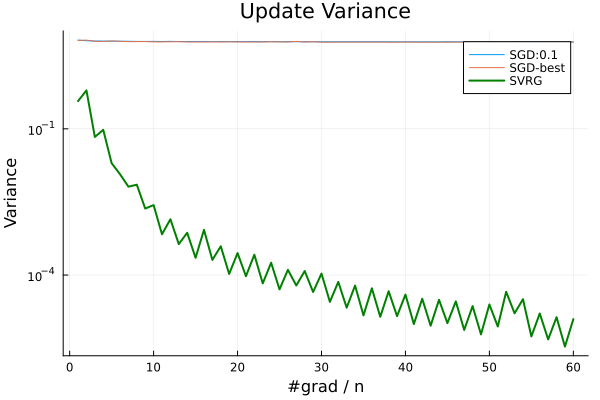

In [31]:
_, var_sgd10 = sgd(∇f, x, Atrain, btrain, 0.1, variance_sgd)
_, var_sgd45 = sgd(∇f, x, Atrain, btrain, 0.45, variance_sgd)
_, var_svrg = svrg(∇f, x, Atrain, btrain, 0.025, variance_svrg)

p3 = plot(yscale = :log10, yticks = [1e2, 1e-1, 1e-4, 1e-7, 1e-10, 1e-13, 1e-16], xlabel = "#grad / n", ylabel = "Variance", title = "Update Variance", legend = :topright)

plot!(p3, var_sgd10.variance, label="SGD:0.1")
plot!(p3, var_sgd45.variance, label="SGD-best")
plot!(p3, var_svrg.variance,label="SVRG", linewidth = 2, color = :green)

display(p3)